# Evaluate ERA-5 downscaling: minimum and maximum temperatures

We used **1981-1991 as training** period and **1991-2010 as reference** period. The results shown in this notebook are based on the model predictions on the reference period.

**Predictors on pressure levels (500, 850)**:
- Geopotential (z)
- Temperature (t)
- Zonal wind (u)
- Meridional wind (v)
- Specific humidity (q)

**Predictors on surface**:
- Surface pressure (p)

**Auxiliary predictors**:
- Elevation from Copernicus EU-DEM v1.1 (dem)
- Day of the year (doy)

Define the predictand and the model to evaluate:

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax'

In [2]:
from pathlib import Path

# model filename to evaluate
FILENAME = 'LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_dem_sa_doy.nc'  # change me!
TARGET_PATH = '/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/larger_alps/grid_search/'
TARGET_PATH = Path(TARGET_PATH)

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

# locals
from downscaleml.main.inputoutput import ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH
from climax.core.utils import plot_loss
from climax.core.dataset import ERA5Dataset
from downscaleml.core.utils import search_files

In [4]:
type(ERA5_PATH)

pathlib.PosixPath

In [5]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'pr': 'precipitation', 'tasmean': 'mean temperature'}

### Model architecture

### Load datasets

In [6]:
# model predictions
y_pred = xr.open_dataset(TARGET_PATH.joinpath(PREDICTAND, FILENAME))
y_pred

<xarray.Dataset>
Dimensions:  (time: 1826, y: 103, x: 125)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 50.52 50.45 50.37 50.3 50.23 ... 43.27 43.2 43.13 43.05
  * x        (x) float64 3.715 3.822 3.93 4.038 ... 16.75 16.85 16.96 17.07
Data variables:
    tasmean  (time, y, x) float64 ...

In [7]:
TARGET_PATH.joinpath(PREDICTAND, FILENAME)

PosixPath('/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/larger_alps/grid_search/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_dem_sa_doy.nc')

In [8]:
# target values: observations
y_true = xr.open_dataset(search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop())
y_true


<xarray.Dataset>
Dimensions:            (longitude: 125, latitude: 103, time: 13149)
Coordinates:
  * longitude          (longitude) float64 3.715 3.822 3.93 ... 16.96 17.07
  * latitude           (latitude) float64 50.52 50.45 50.37 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, latitude, longitude) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Sun Jul 09 20:20:26 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)


In [10]:
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true.rename({'longitude': 'x','latitude': 'y'})
y_true

<xarray.Dataset>
Dimensions:            (x: 125, y: 103, time: 1826)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2016-01-01 ... 2020-12-30
Data variables:
    tasmean            (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Sun Jul 09 20:20:26 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [11]:
# align datasets and mask missing values in model predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')
y_pred = y_pred.where(~np.isnan(y_true), other=np.nan)

## Model validation

In [12]:
y_true

<xarray.DataArray 'tasmean' (time: 1826, y: 103, x: 125)>
array([[[279.04572, 279.14667, ..., 271.20514, 270.89688],
        [279.28485, 279.49783, ..., 271.2713 , 271.20868],
        ...,
        [287.00836, 287.07147, ..., 280.20163, 279.5809 ],
        [287.3286 , 287.45572, ..., 282.72238, 280.95688]],

       [[281.5531 , 281.49622, ..., 265.88287, 265.60486],
        [281.81924, 281.76315, ..., 266.04095, 266.31705],
        ...,
        [286.61035, 286.7169 , ..., 282.1036 , 281.79193],
        [286.62836, 286.72577, ..., 283.92664, 282.50775]],

       ...,

       [[275.81387, 275.791  , ..., 278.21567, 277.89096],
        [276.07202, 276.11017, ..., 278.00552, 278.72177],
        ...,
        [283.20844, 283.39496, ..., 287.44772, 287.12842],
        [283.4836 , 283.63986, ..., 289.31668, 288.18918]],

       [[276.3766 , 276.4805 , ..., 274.73148, 274.51703],
        [276.55826, 276.66946, ..., 274.81747, 275.04932],
        ...,
        [282.38354, 282.46967, ..., 286.8248 , 286.50635],
        [282.5214 , 282.59323, ..., 288.1987 , 287.06546]]], dtype=float32)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2016-01-01 ... 2020-12-30
Attributes: (12/23)
    standard_name:                            air_temperature
    long_name:                                2 metre temperature
    units:                                    K
    GRIB_dataType:                            an
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_latitudeOfSouthernPoleInDegrees:     -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  342.514057
    GRIB_longitudeOfSouthernPoleInDegrees:    0.0
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K

In [13]:
y_pred

<xarray.DataArray 'tasmean' (time: 1826, y: 103, x: 125)>
array([[[278.54567687, 278.67892308, 278.66817903, ..., 271.89191115,
         271.64056659, 270.64856443],
        [278.75728292, 278.8607178 , 279.00654079, ..., 271.42222092,
         271.74222349, 272.29521929],
        [278.68400999, 278.41399996, 278.40159352, ..., 270.40813677,
         271.44635187, 271.86306197],
        ...,
        [286.73591338, 287.05891537, 287.33452504, ..., 283.49515007,
         282.85781525, 281.42137551],
        [287.03577297, 287.29456125, 287.02417   , ..., 281.58466248,
         281.61227908, 280.22461498],
        [287.13449786, 287.11103508, 287.19248462, ..., 284.02260757,
         283.3924995 , 280.99414056]],

       [[281.50156733, 281.43090915, 281.35947854, ..., 266.29225203,
         266.00624602, 265.83677842],
        [281.51777031, 281.65437813, 281.60529626, ..., 266.58741627,
         266.50709768, 266.70463376],
        [281.54167693, 281.1751204 , 281.32911969, ..., 266.04192928,
         265.9196913 , 266.69811977],
...
        [283.17427663, 283.19682006, 283.19781015, ..., 288.53555798,
         288.24954731, 287.64271682],
        [283.20708699, 283.52392944, 283.61224563, ..., 287.83698119,
         288.03445383, 287.4895486 ],
        [283.34992856, 283.65764228, 284.03861247, ..., 289.23975294,
         289.20265311, 288.32309582]],

       [[276.43480099, 276.32491226, 276.33572834, ..., 274.53647724,
         274.36210426, 273.79528361],
        [276.81905792, 276.61098992, 276.54210108, ..., 273.57421087,
         274.21397021, 274.12221981],
        [276.51334059, 276.33205443, 276.40492726, ..., 272.90348959,
         272.66594729, 273.90471554],
        ...,
        [282.13364361, 282.1153769 , 282.29465516, ..., 287.68508141,
         287.76440598, 287.1020786 ],
        [282.23144787, 282.33961783, 282.69074532, ..., 286.85655644,
         286.98068275, 287.09214291],
        [282.73980178, 282.90719456, 282.74955073, ..., 288.53878221,
         288.44676999, 287.52245545]]])
Coordinates:
  * time               (time) datetime64[ns] 2016-01-01 ... 2020-12-30
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
    heightAboveGround  float64 ...

In [14]:
y_pred = y_pred - 273.15
y_true = y_true - 273.15

In [15]:
# calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [16]:
y_pred_mm

<xarray.DataArray 'tasmean' (month: 12, y: 103, x: 125)>
array([[[ 3.99174909e+00,  3.97574214e+00,  3.98146602e+00, ...,
         -3.77972785e-01, -2.60205319e-01, -4.48775607e-01],
        [ 4.16247010e+00,  4.26229822e+00,  4.25094617e+00, ...,
         -1.19838024e+00, -4.51827354e-01,  1.60210040e-02],
        [ 4.01271519e+00,  3.76308987e+00,  3.84738642e+00, ...,
         -2.03474980e+00, -1.69240685e+00, -6.10709920e-01],
        ...,
        [ 1.08133017e+01,  1.09277083e+01,  1.09734787e+01, ...,
          1.10164991e+01,  1.11956963e+01,  1.01331471e+01],
        [ 1.10039758e+01,  1.11031770e+01,  1.11375041e+01, ...,
          9.83576636e+00,  9.87220164e+00,  9.43483034e+00],
        [ 1.11958317e+01,  1.12935071e+01,  1.13020209e+01, ...,
          1.13149359e+01,  1.11612827e+01,  1.00299594e+01]],

       [[ 4.99943087e+00,  5.01230676e+00,  5.06240822e+00, ...,
          2.23886534e+00,  2.31050147e+00,  2.14779618e+00],
        [ 5.25786598e+00,  5.33567737e+00,  5.34567328e+00, ...,
          1.38740562e+00,  2.13541416e+00,  2.62138773e+00],
        [ 5.09786156e+00,  4.82832207e+00,  4.90075078e+00, ...,
          3.96498619e-01,  8.04287455e-01,  1.99016406e+00],
...
        [ 1.43493001e+01,  1.44591797e+01,  1.45096052e+01, ...,
          1.62330745e+01,  1.62078862e+01,  1.53032470e+01],
        [ 1.44715014e+01,  1.45888575e+01,  1.46476240e+01, ...,
          1.54911739e+01,  1.54180698e+01,  1.49303287e+01],
        [ 1.46336103e+01,  1.47276580e+01,  1.47950601e+01, ...,
          1.65838986e+01,  1.64109532e+01,  1.55132557e+01]],

       [[ 5.13981285e+00,  5.14546247e+00,  5.18607583e+00, ...,
          2.38857488e+00,  2.45385390e+00,  2.28905930e+00],
        [ 5.37978524e+00,  5.42899765e+00,  5.45483534e+00, ...,
          1.59556011e+00,  2.37419802e+00,  2.83512326e+00],
        [ 5.18808203e+00,  4.96113256e+00,  5.01255464e+00, ...,
          6.00790838e-01,  1.05101214e+00,  2.19007586e+00],
        ...,
        [ 1.22021377e+01,  1.23047300e+01,  1.23535483e+01, ...,
          1.29318142e+01,  1.28828475e+01,  1.18272905e+01],
        [ 1.23839879e+01,  1.24956012e+01,  1.25385110e+01, ...,
          1.18299156e+01,  1.18016261e+01,  1.11621783e+01],
        [ 1.25731803e+01,  1.26904958e+01,  1.27579913e+01, ...,
          1.33180895e+01,  1.30973552e+01,  1.19547239e+01]]])
Coordinates:
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
    heightAboveGround  float64 ...
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [17]:
y_true_mm

<xarray.DataArray 'tasmean' (month: 12, y: 103, x: 125)>
array([[[ 4.09377146e+00,  4.04749966e+00,  4.07140541e+00, ...,
         -1.34634688e-01, -7.13638775e-03, -1.46827355e-01],
        [ 4.30060577e+00,  4.34350586e+00,  4.34285164e+00, ...,
         -8.03234458e-01, -6.23013414e-02,  3.59852642e-01],
        [ 4.13744402e+00,  3.90728402e+00,  3.94442487e+00, ...,
         -1.77541065e+00, -1.21269274e+00, -2.00047061e-01],
        ...,
        [ 1.06935873e+01,  1.08360243e+01,  1.09139585e+01, ...,
          1.07534542e+01,  1.08572636e+01,  9.74860764e+00],
        [ 1.09087811e+01,  1.10277672e+01,  1.11121874e+01, ...,
          9.51101208e+00,  9.52820301e+00,  9.01574135e+00],
        [ 1.11201744e+01,  1.12110281e+01,  1.12823668e+01, ...,
          1.11230421e+01,  1.09027882e+01,  9.76825047e+00]],

       [[ 5.07172918e+00,  5.05009365e+00,  5.09870148e+00, ...,
          2.15212321e+00,  2.25022650e+00,  2.15210485e+00],
        [ 5.31383610e+00,  5.40289068e+00,  5.41413116e+00, ...,
          1.34395075e+00,  2.16170359e+00,  2.71566939e+00],
        [ 5.18008280e+00,  4.93566132e+00,  4.98089409e+00, ...,
          3.05534899e-01,  7.73204744e-01,  2.05342007e+00],
...
          1.64594765e+01,  1.66173344e+01,  1.56287088e+01],
        [ 1.44120569e+01,  1.44939384e+01,  1.45587626e+01, ...,
          1.54150801e+01,  1.54836178e+01,  1.51641273e+01],
        [ 1.45742397e+01,  1.46414547e+01,  1.47008915e+01, ...,
          1.67910538e+01,  1.66173115e+01,  1.56364651e+01]],

       [[ 5.12778044e+00,  5.12579775e+00,  5.17670727e+00, ...,
          2.48883200e+00,  2.63479090e+00,  2.52048922e+00],
        [ 5.34922934e+00,  5.42377234e+00,  5.43827152e+00, ...,
          1.73319590e+00,  2.57229853e+00,  3.05518794e+00],
        [ 5.21698713e+00,  5.00982714e+00,  5.05369568e+00, ...,
          7.37529635e-01,  1.31884265e+00,  2.42561102e+00],
        ...,
        [ 1.19777460e+01,  1.21052647e+01,  1.21668701e+01, ...,
          1.30442343e+01,  1.32055502e+01,  1.20463982e+01],
        [ 1.22191277e+01,  1.23172960e+01,  1.23787956e+01, ...,
          1.17039862e+01,  1.17671432e+01,  1.11929998e+01],
        [ 1.24348822e+01,  1.25121231e+01,  1.25669689e+01, ...,
          1.34470119e+01,  1.32318516e+01,  1.19788265e+01]]],
      dtype=float32)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [18]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [19]:
# compute daily anomalies
y_pred_anom = ERA5Dataset.anomalies(y_pred, timescale='time.month')
y_true_anom = ERA5Dataset.anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [20]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 1.00
R2 on daily anomalies: 0.95


### Mean error (Bias)

Calculate yearly average bias over entire reference period:

In [21]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('(Model) Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()))

(Model) Yearly average bias of tasmean: -0.01°C


### Mean absolute error (MAE)

In [22]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('(Model) Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()))

(Model) Yearly average MAE of tasmean: 0.14°C


### Root mean squared error (RMSE)

In [23]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('(Model) Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()))

(Model) Yearly average RMSE of tasmean: 0.18°C


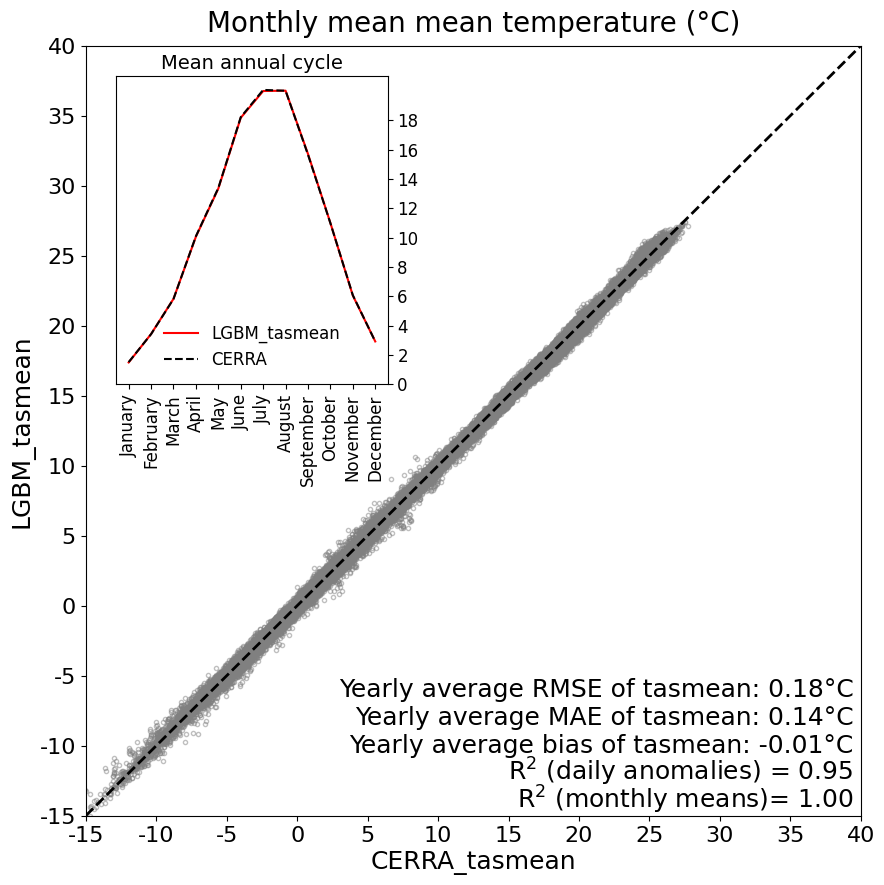

In [25]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('CERRA_tasmean', fontsize=18)
ax.set_ylabel('LGBM_tasmean', fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='-', color='r', label='LGBM_tasmean')
axins.plot(y_true_ac.values, ls='--', color='k', label='CERRA')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

#plt.savefig('mslp.png', dpi=300, bbox_inches='tight')
